In [2]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Shared Functions

In [1]:
pth = '/content/drive/MyDrive/Colab Notebooks/Thesis'

# Available states-action pairs:
state_action_pair = {'all': 'all', # all actions
                    'bpbd': 'draw', # actions 2/3 
                    'apbd': ['discard', 'knock'], # actions 6-57, 58-109
                    'apad': 'knock_bin'} # binary action

# All Possible Classes
all_classes = ['SP0','SP1','Draw','Pickup','DH','GIN',
               'AS', '2S', '3S', '4S', '5S', '6S', '7S', '8S', '9S', 'TS', 'JS', 'QS', 'KS',
               'AH', '2H', '3H', '4H', '5H', '6H', '7H', '8H', '9H', 'TH', 'JH', 'QH', 'KH',
               'AD', '2D', '3D', '4D', '5D', '6D', '7D', '8D', '9D', 'TD', 'JD', 'QD', 'KD',
               'AC', '2C', '3C', '4C', '5C', '6C', '7C', '8C', '9C', 'TC', 'JC', 'QC', 'KC',
               'AS', '2S', '3S', '4S', '5S', '6S', '7S', '8S', '9S', 'TS', 'JS', 'QS', 'KS',
               'AH', '2H', '3H', '4H', '5H', '6H', '7H', '8H', '9H', 'TH', 'JH', 'QH', 'KH',
               'AD', '2D', '3D', '4D', '5D', '6D', '7D', '8D', '9D', 'TD', 'JD', 'QD', 'KD',
               'AC', '2C', '3C', '4C', '5C', '6C', '7C', '8C', '9C', 'TC', 'JC', 'QC', 'KC']

## Imports

In [2]:
import copy
import numpy as np
import pandas as pd
import os
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

## cardDataset Class

In [3]:
class cardDataset(data.Dataset):

    def __init__(self, features, labels):

        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

## Balance

In [4]:
def balanceClasses(states, actions):
    class_count = np.sum(actions, axis=0)
    zero_count_ind = np.where(class_count == 0)[0]
    class_count[zero_count_ind] = 1e10
    min_count = np.min(class_count)
    min_count_ind = np.argmin(class_count)
    # Get indices of current class 
    action_ind = np.where(actions[:,min_count_ind] == 1)[0]
    actions_bal = actions[action_ind]
    states_bal = states[action_ind]
    for curr_ind in range(actions.shape[1]): 
        if curr_ind not in zero_count_ind and curr_ind != min_count_ind:
            action_ind = np.where(actions[:,curr_ind] == 1)[0]
            actions_temp = actions[action_ind]
            states_temp = states[action_ind]

            random_indices = np.random.choice(actions_temp.shape[0], size=min_count, replace=False)
            actions_temp = actions_temp[random_indices]
            states_temp = states_temp[random_indices]

            actions_bal = np.concatenate((actions_bal, actions_temp))
            states_bal = np.concatenate((states_bal, states_temp))
    return states_bal, actions_bal

## Prune States/Actions


In [5]:
# prunable states
prune_states = {'currHand': 0, 'topCard': 1,
                'deadCard': 2, 'oppCard': 3,
                'unknownCard': 4}

def pruneStates(states, stateList=[]):
    ''' States '''
    # (0) ignore current hand
    # states[:,(260-52*5):(260-52*4)] = 0
    # (1) ignore top card feature
    # states[:,(260-52*4):(260-52*3)] = 0
    # (2) ignore dead cards feature
    # states[:,(260-52*3):(260-52*2)] = 0
    # (3) ignore opponent known cards feature
    # states[:,(260-52*2):(260-52*1)] = 0
    # (4) ignore unknown cards feature
    # states[:,(260-52):(260-52*0)] = 0
    for s in stateList:
        try: 
            print('pruning state: {}'.format(s))
            states[:,(260-52*(5-prune_states[s])):(260-52*(4-prune_states[s]-1))] = 0
        except:
            print('{} is not a state'.format(s))
            pass
    return states

# chooseable actions
prune_actions = {'all': 0,'draw': 1,'discard': 2,'knock': 3,'knock_bin': 4}

def chooseActions(actions, classes, actionChoice):
    ''' Actions '''
    # (0) all:          actions
    #       (x) score_player: actions[:,0:2]
    # (1) draw:         actions[:,2:4]
    #       (x) deadHand:     actions[:,4]
    #       (x) gin:          actions[:,5]
    # (2) discard:      actions[:,6:58]
    # (3) knock:        actions[:,58:]
    # (4) knock_bin:    actions

    if actionChoice == 'all':
        return actions, classes
    elif actionChoice == 'draw':
        return actions[:,2:4], classes[2:4]
    elif actionChoice == 'discard':
        return actions[:,6:58], classes[6:58]
    elif actionChoice == 'knock':
        return actions[:,58:], classes[58:]
    elif actionChoice == 'knock_bin':
        return actions, ["No Knock", "Knock"]

    else:
        print('action selected not allowed')
        return actions, classes

## Models

### 1 Hidden Layer: input_size*2

i.e. 1 Hidden Layer: input_size*2

In [6]:
class MLP(nn.Module):

    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        ''' Layer 1 '''
        self.l1 = nn.Linear(input_size, input_size*2)

        ''' Layer 2 '''
        self.l2 = nn.Linear(input_size*2, output_size)
        
        ''' Activation Function '''
        self.sig = nn.Sigmoid()

    def forward(self, features):
        try:
            x = self.l1(features.cuda())
        except:
            x = self.l1(features)
        # x = self.l1(features)
        x = self.sig(x)
        x = self.l2(x)
        return self.sig(x)

## Load Data and Model

In [7]:
def load_data(data, label, batch_size=1000, shuffle=False):
    '''
    Load dataset according to batch_size given
    '''
    data_set = cardDataset(data, label)
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=shuffle)
    return data_loader


def load_test_data(numGames):
    '''
    Load test data
    '''
    states_test = np.load('{}/s_{}k.npy'.format(data_pth,numGames//1000))
    actions_test = np.load('{}/a_{}k.npy'.format(data_pth,numGames//1000))

    # prune states
    states_test = pruneStates(states_test, pruneStatesList)

    # choosable actions
    actions_test, classes = chooseActions(actions_test, all_classes, actionChoice)
    test_loader = load_data(states_test, actions_test)
    return test_loader, classes


def load_model(lr=0.001, input_size=None, output_size=None,
               model=None, pre_train=False, model_PT=None):
    loss_fnc = torch.nn.MSELoss()
    if model is None:
        try:
            model = MLP(input_size, output_size).cuda()
        except:
            model = MLP(input_size, output_size)
        # model = MLP(input_size)
        if pre_train:
            pre_train_model = torch.load(model_PT)
            try:
                pre_train_model.l1 = pre_train_model.l1.cuda()
                model.l1.weight = pre_train_model.l1.weight.cuda()
                model.l1.bias = pre_train_model.l1.bias.cuda()
            except:
                model.l1.weight = pre_train_model.l1.weight
                model.l1.bias = pre_train_model.l1.bias
        # print(model.l1.weight.device)
        # print(model.l1.bias.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        return model, loss_fnc, optimizer
    return model, loss_fnc, _

## Evaluate

In [8]:
def evaluate(model, data_loader, loss_fnc):

    total_corr = 0
    accum_loss = 0
    for i, data in enumerate(data_loader):
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)
        outputs = model(inputs)
        try:
            batch_loss = loss_fnc(input=outputs, target=labels.cuda())
        except:
            batch_loss = loss_fnc(input=outputs, target=labels)
        # batch_loss = loss_fnc(input=outputs, target=labels)

        guess = torch.argmax(outputs, dim=1)
        # print(guess)
        try:
            answer = torch.argmax(labels.cuda(), dim=1)
        except:
            answer = torch.argmax(labels, dim=1)
        # answer = torch.argmax(labels, dim=1)

        corr = guess == answer
        total_corr += int(corr.sum())
        accum_loss += batch_loss

    acc = float(total_corr)/len(data_loader.dataset)
    loss = accum_loss/(i+1)
    return acc, loss.item() 

## Train

In [9]:
def train(train_loader, val_loader, batch_size=1000, lr=0.001, epochs=100,
          verbose=False, pre_train=False, model_PT=None):

    input_size = len(train_loader.dataset.features[0])
    output_size = len(val_loader.dataset.labels[0])
    # input_size = data_train.shape[1]
    model, loss_fnc, optimizer = load_model(lr, input_size, output_size,
                                            pre_train=pre_train, model_PT=model_PT)

    max_val_acc = 0
    min_val_loss = np.inf
    train_acc, train_loss = [], []
    val_acc, val_loss = [], []
    start_time = time.time()

    for epoch in range(epochs):
        accum_loss = 0
        total_corr = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.type(torch.FloatTensor)
            labels = labels.type(torch.FloatTensor)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            try:
                batch_loss = loss_fnc(input=outputs, target=labels.cuda())
            except:
                batch_loss = loss_fnc(input=outputs, target=labels)
            # batch_loss = loss_fnc(input=outputs, target=labels)
            accum_loss += batch_loss
            batch_loss.backward()
            optimizer.step()

            guess = torch.argmax(outputs, dim=1)
            # print(guess)
            try:
                answer = torch.argmax(labels.cuda(), dim=1)
            except:
                answer = torch.argmax(labels, dim=1)
            # answer = torch.argmax(labels, dim=1)
            # print(labels)
            corr = guess == answer
            total_corr += int(corr.sum())

        # evaluate per epoch
        vacc, vloss = evaluate(model, val_loader, loss_fnc)
        val_acc.append(vacc)
        val_loss.append(vloss)
        train_loss.append(accum_loss.item()/(i+1))
        train_acc.append(float(total_corr)/len(train_loader.dataset))
        # best acc model
        if vacc > max_val_acc:
            max_val_acc = vacc
            epoch_acc = epoch
            model_acc = copy.deepcopy(model) 
        # best loss model
        if vloss < min_val_loss:
            min_val_loss = vloss
            epoch_loss = epoch
            model_loss = copy.deepcopy(model)

        if verbose:
            # print records
            print("Epoch: {} | Train Loss: {:.8f} | Train acc: {:.6f}"
                .format(epoch + 1, train_loss[epoch], train_acc[epoch]))
            print("              Val Loss: {:.8f} |   Val acc: {:.6f}"
                .format(val_loss[epoch], val_acc[epoch]))
        accum_loss = 0.0
        total_corr = 0


    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total training time elapsed: {:.2f} seconds".format(elapsed_time))
    plotTrain(train_acc, val_acc, epoch_acc, 'Accuracy',batch_size, lr)
    plotTrain(train_loss, val_loss, epoch_loss, 'Loss',batch_size, lr)

    return model, model_acc, model_loss

## Plot Functions

In [10]:
def plotTrain(train, val, epoch, label, bs, lr):
    plt.figure()
    plt.title("{} vs. Epoch".format(label), fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(label, fontsize=12)
    plt.plot(train, label='Training {}'.format(label))
    plt.plot(val, label='Validation {}'.format(label))
    plt.axvline(epoch, color='red', label='Best Epoch: {}'.format(epoch+1))
    plt.plot(epoch, val[epoch], marker='o', color="red", label="{}: {:.4f}"
             .format(label, val[epoch]))
    plt.legend()
    plt.savefig('{}/{}_bs_{}_lr_{}.png'.format(plot_pth,label,bs,lr),
                bbox_inches='tight')
    plt.show()
    plt.close()


def evaluate_confusion_matrix(model, data_loader):
    """
    Run the model on the test set and generate the confusion matrix.

    Args:
        model: PyTorch neural network object
        data_loader: PyTorch data loader for the dataset
    Returns:
        cm: A NumPy array denoting the confusion matrix
    """
    val_labels = np.array([], dtype=np.int64)
    val_preds = np.array([], dtype=np.int64)

    for i, data in enumerate(data_loader, 0):
        vinputs, vlabels = data
        vinputs = vinputs.type(torch.FloatTensor)
        vlabels = vlabels.type(torch.FloatTensor)
        voutputs = model(vinputs)
        vguess = torch.argmax(voutputs.cpu(), dim=1)
        vlabels = torch.argmax(vlabels.cpu(), dim=1)
        val_labels = np.concatenate((val_labels, vlabels))
        val_preds = np.concatenate((val_preds, vguess))
    
    # cm = confusion_matrix(val_labels, val_preds)
    cm_temp = np.zeros([voutputs.shape[1],voutputs.shape[1]], dtype=np.int64)
    for i in range(len(val_labels)):
        cm_temp[val_labels[i]][val_preds[i]] += 1
    cm = cm_temp
    print('Accuracy: {:.2f}'.format(100*(val_labels == val_preds).sum() /len(val_labels)))
    return cm


# Function based off
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes, mode,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Args:
        cm: A NumPy array denoting the confusion matrix
        classes: A list of strings denoting the name of the classes
        normalize: Boolean whether to normalize the confusion matrix or not
        title: String for the title of the plot
        cmap: Colour map for the plot
    """
    # normalize
    if normalize:
        plot_name = 'CM_norm'
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-5)
        print("Normalized confusion matrix")
    else:
        plot_name = 'CM'
        print('Confusion matrix, without normalization')

    # limit figure size
    if cm.shape[0] < 52:
        plt.figure(facecolor='white')
    else:
        plt.figure(figsize=cm.shape, facecolor='white')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if mode == 'full':
        plt.savefig('{}/{}_G_{}k.png'.format(plot_pth,plot_name,currGames//1000),
                    bbox_inches='tight')
    else:
        plt.savefig('{}/{}_G_{}k_{}.png'.format(plot_pth,plot_name,currGames//1000,mode),
                    bbox_inches='tight')        
    if cm.shape[0] < 53:
        plt.show()
    plt.close()
    return


def plot_cm(classes, model, data_loader, mode='full'):

    cm = evaluate_confusion_matrix(model, data_loader)
    plot_confusion_matrix(cm, classes, mode,
                        normalize=True,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues)
    plot_confusion_matrix(cm, classes, mode,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues)

# All

i.e. Before Pickup, Before Discard: Draw (bpbd_draw)

## all_states_all_actions

Specify the following parameters:

- Data Selection:
 - model_name
 - state-action pair
```r
state_action_pair = {'all': 'all', # all actions
                    'bpbd': 'draw', # actions 2/3 
                    'apbd': ['discard', 'knock'], # actions 6-57, 58-109
                    'apad': 'knock_bin'}
```
 - numGames
 - pruneStatesList
 ```r
 {'currHand','topCard','deadCard','oppCard','unknownCard'}
 ```
 - actionChoice = 'all'
```r
{'all','draw','discard','knock'}
```

- Model Parameters:

| Parameter     | Type      |Default|
| ------------- |:---------:| -----:|
| batch_size    | int       | 1000  |
| learning_rate | float     | 0.001 |
| epoch         | int       | 100   |
| pre_train     | bool (T/F)| False |
| model_PT      | str (path)| null  |

In [11]:
# model name
model_name = 'all_states_all_actions'

# state_action pair, and dataset selection
state = 'all'
action = 'all'
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 100

# Pretrain model
pre_train = False
model_PT = ''

### Directories

In [12]:
# create model and plot directories if do not exist

# model directories
state_pth = '{}/models/{}'.format(pth,state)
if not os.path.exists(state_pth):
    os.mkdir(state_pth)
action_pth = '{}/{}'.format(state_pth,action)
if not os.path.exists(action_pth):
    os.mkdir(action_pth)
model_pth = '{}/{}'.format(action_pth,model_name)
if not os.path.exists(model_pth):
    os.mkdir(model_pth)

# plot directories
state_pth = '{}/plots/{}'.format(pth,state)
if not os.path.exists(state_pth):
    os.mkdir(state_pth)
action_pth = '{}/{}'.format(state_pth,action)
if not os.path.exists(action_pth):
    os.mkdir(action_pth)
plot_pth = '{}/{}'.format(action_pth,model_name)
if not os.path.exists(plot_pth):
    os.mkdir(plot_pth)

# data directory
data_pth = '{}/data/{}/{}'.format(pth,state,action)

### Load, Prune, Split Data

In [ ]:
if action in state_action_pair[state]:
    states = np.load('{}/s_{}k.npy'.format(data_pth,numGames//1000))
    actions = np.load('{}/a_{}k.npy'.format(data_pth,numGames//1000))

    # prune states
    states = pruneStates(states, pruneStatesList)

    # choosable actions
    actions, classes = chooseActions(actions, all_classes, actionChoice)

    # balance classes
    if balance:
        states,actions = balanceClasses(states,actions)

    # split train/val
    data_train, data_val, label_train, label_val = train_test_split(states, actions, test_size=0.3, random_state=421)
else:
    print('illegeal state-action pair')

In [ ]:
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

### Train Model

Epoch: 1 | Train Loss: 0.00861330 | Train acc: 0.415339
              Val Loss: 0.00693997 |   Val acc: 0.416195
Epoch: 2 | Train Loss: 0.00612328 | Train acc: 0.418369
              Val Loss: 0.00573224 |   Val acc: 0.416195
Epoch: 3 | Train Loss: 0.00562891 | Train acc: 0.437871
              Val Loss: 0.00556518 |   Val acc: 0.509658
Epoch: 4 | Train Loss: 0.00522910 | Train acc: 0.571243
              Val Loss: 0.00476925 |   Val acc: 0.606442
Epoch: 5 | Train Loss: 0.00446489 | Train acc: 0.630431
              Val Loss: 0.00431618 |   Val acc: 0.644086
Epoch: 6 | Train Loss: 0.00414909 | Train acc: 0.660784
              Val Loss: 0.00404564 |   Val acc: 0.673516
Epoch: 7 | Train Loss: 0.00391609 | Train acc: 0.685580
              Val Loss: 0.00383375 |   Val acc: 0.695596
Epoch: 8 | Train Loss: 0.00372823 | Train acc: 0.704410
              Val Loss: 0.00368163 |   Val acc: 0.706945
Epoch: 9 | Train Loss: 0.00357679 | Train acc: 0.714742
              Val Loss: 0.00352609 |   V

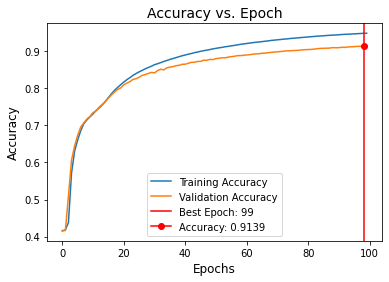

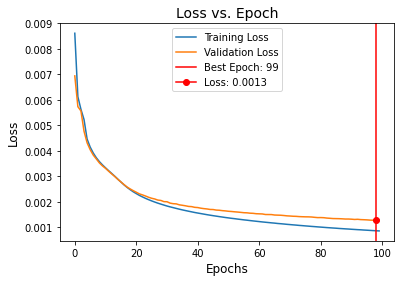

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, batch_size, lr, epochs, verbose=True, pre_train=pre_train, model_PT=model_PT)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

In [13]:
model = torch.load('{}/model.pt'.format(model_pth))
model_acc = torch.load('{}/model_acc.pt'.format(model_pth))
model_loss = torch.load('{}/model_loss.pt'.format(model_pth))

##### Train Set

In [ ]:
currGames = 8000
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, train_loader)

##### Validation Set

In [ ]:
currGames = 8000
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, val_loader, mode='val')

##### Test Set (6k)

In [ ]:
currGames = 6000
test_loader_6k, classes = load_test_data(currGames)
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader_6k)

##### Test Set (2k)

Test on all three models generated:

In [14]:
currGames = 2000
test_loader_2k, classes = load_test_data(currGames)
model = torch.load('{}/model.pt'.format(model_pth))
model_acc = torch.load('{}/model_acc.pt'.format(model_pth))
model_loss = torch.load('{}/model_loss.pt'.format(model_pth))

###### all epoch

In [15]:
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader_2k)

Accuracy: 93.93
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [16]:
model_acc, loss_fnc, _ = load_model(model=model_acc)
plot_cm(classes, model_acc, test_loader_2k, mode='acc')

Accuracy: 93.90
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [17]:
model_loss, loss_fnc, _ = load_model(model=model_loss)
plot_cm(classes, model_loss, test_loader_2k, mode='loss')

Accuracy: 93.90
Normalized confusion matrix
Confusion matrix, without normalization


## all_states_all_actions_PT

Specify the following parameters:

- Data Selection:
 - model_name
 - state-action pair
```r
state_action_pair = {'all': 'all', # all actions
                    'bpbd': 'draw', # actions 2/3 
                    'apbd': ['discard', 'knock'], # actions 6-57, 58-109
                    'apad': 'knock_bin'}
```
 - numGames
 - pruneStatesList
 ```r
 {'currHand','topCard','deadCard','oppCard','unknownCard'}
 ```
 - actionChoice = 'all'
```r
{'all','draw','discard','knock'}
```

- Model Parameters:

| Parameter     | Type      |Default|
| ------------- |:---------:| -----:|
| batch_size    | int       | 1000  |
| learning_rate | float     | 0.001 |
| epoch         | int       | 100   |
| pre_train     | bool (T/F)| False |
| model_PT      | str (path)| null  |

In [18]:
# model name
model_name = 'all_states_all_actions_PT'

# state_action pair, and dataset selection
state = 'all'
action = 'all'
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 100

# Pretrain model
pre_train = True
model_PT = '/content/drive/MyDrive/Colab Notebooks/Thesis/models/apbd/knock/all_states_all_actions/model.pt'

### Directories

In [19]:
# create model and plot directories if do not exist

# model directories
state_pth = '{}/models/{}'.format(pth,state)
if not os.path.exists(state_pth):
    os.mkdir(state_pth)
action_pth = '{}/{}'.format(state_pth,action)
if not os.path.exists(action_pth):
    os.mkdir(action_pth)
model_pth = '{}/{}'.format(action_pth,model_name)
if not os.path.exists(model_pth):
    os.mkdir(model_pth)

# plot directories
state_pth = '{}/plots/{}'.format(pth,state)
if not os.path.exists(state_pth):
    os.mkdir(state_pth)
action_pth = '{}/{}'.format(state_pth,action)
if not os.path.exists(action_pth):
    os.mkdir(action_pth)
plot_pth = '{}/{}'.format(action_pth,model_name)
if not os.path.exists(plot_pth):
    os.mkdir(plot_pth)

# data directory
data_pth = '{}/data/{}/{}'.format(pth,state,action)

### Load, Prune, Split Data

In [ ]:
if action in state_action_pair[state]:
    states = np.load('{}/s_{}k.npy'.format(data_pth,numGames//1000))
    actions = np.load('{}/a_{}k.npy'.format(data_pth,numGames//1000))

    # prune states
    states = pruneStates(states, pruneStatesList)

    # choosable actions
    actions, classes = chooseActions(actions, all_classes, actionChoice)

    # balance classes
    if balance:
        states,actions = balanceClasses(states,actions)

    # split train/val
    data_train, data_val, label_train, label_val = train_test_split(states, actions, test_size=0.3, random_state=421)
else:
    print('illegeal state-action pair')

In [ ]:
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

### Train Model

Epoch: 1 | Train Loss: 0.00852163 | Train acc: 0.416026
              Val Loss: 0.00720526 |   Val acc: 0.416195
Epoch: 2 | Train Loss: 0.00656159 | Train acc: 0.421070
              Val Loss: 0.00577121 |   Val acc: 0.442361
Epoch: 3 | Train Loss: 0.00517604 | Train acc: 0.589000
              Val Loss: 0.00470937 |   Val acc: 0.670652
Epoch: 4 | Train Loss: 0.00436557 | Train acc: 0.688502
              Val Loss: 0.00413543 |   Val acc: 0.700908
Epoch: 5 | Train Loss: 0.00394480 | Train acc: 0.709830
              Val Loss: 0.00382280 |   Val acc: 0.716181
Epoch: 6 | Train Loss: 0.00368970 | Train acc: 0.722615
              Val Loss: 0.00361749 |   Val acc: 0.726390
Epoch: 7 | Train Loss: 0.00349213 | Train acc: 0.733777
              Val Loss: 0.00344025 |   Val acc: 0.736009
Epoch: 8 | Train Loss: 0.00331374 | Train acc: 0.745719
              Val Loss: 0.00328405 |   Val acc: 0.744592
Epoch: 9 | Train Loss: 0.00314325 | Train acc: 0.757967
              Val Loss: 0.00312285 |   V

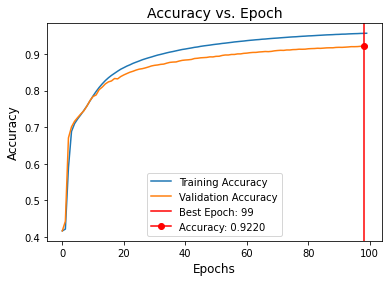

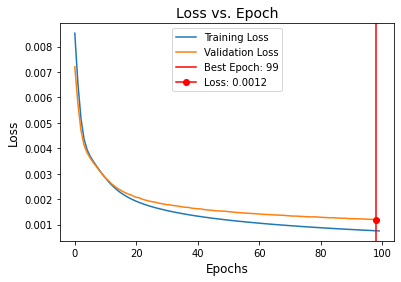

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, batch_size, lr, epochs, verbose=True, pre_train=pre_train, model_PT=model_PT)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

In [20]:
model = torch.load('{}/model.pt'.format(model_pth))
model_acc = torch.load('{}/model_acc.pt'.format(model_pth))
model_loss = torch.load('{}/model_loss.pt'.format(model_pth))

##### Train Set

In [ ]:
currGames = 8000
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, train_loader)

##### Validation Set

In [ ]:
currGames = 8000
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, val_loader, mode='val')

##### Test Set (6k)

In [ ]:
currGames = 6000
test_loader_6k, classes = load_test_data(currGames)
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader_6k)

##### Test Set (2k)

Test on all three models generated:

In [21]:
currGames = 2000
test_loader_2k, classes = load_test_data(currGames)
model = torch.load('{}/model.pt'.format(model_pth))
model_acc = torch.load('{}/model_acc.pt'.format(model_pth))
model_loss = torch.load('{}/model_loss.pt'.format(model_pth))

###### all epoch

In [22]:
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader_2k)

Accuracy: 94.72
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [23]:
model_acc, loss_fnc, _ = load_model(model=model_acc)
plot_cm(classes, model_acc, test_loader_2k, mode='acc')

Accuracy: 94.77
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [24]:
model_loss, loss_fnc, _ = load_model(model=model_loss)
plot_cm(classes, model_loss, test_loader_2k, mode='loss')

Accuracy: 94.77
Normalized confusion matrix
Confusion matrix, without normalization
